In [17]:
import numpy as np
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB, MultinomialNB

# Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, plot_roc_curve

# Statistical Tests
from sklearn.model_selection import cross_val_score
from scipy.stats import ttest_ind

# Classifiers comparison on texts with naive Bayes assumption

In this session of laboratory we compare two models for categorical data probabilistic modeling: 

1. multivariate Bernoulli 
2. multinomial on a dataset 

We adopt a dataset on Twitter messages labelled with emotions (Joy vs Sadness).

Data are loaded into a matrix X adopting a sparse matrix representation, in order to save space and time.
Sparse matrix representation (in the csr format) represents in three "parallel" arrays the value of the matrix cells that are different from zero and the indices of those matrix cells.
The arrays are called: 

1. data
2. row
3. col

More specifically:

- $data_i$ stores the value of the matrix cell $i$ whose indexes are contained in $row_i$ and $col_i$
- $row_i$ stores the index of the row in the matrix of the cell $i$,
- $col_i$ stores the index of the column of the cell $i$.


The data file is in CSV format.

Any Twitter message has been preprocessed by a Natural Language pipeline which eliminated stop words and substituted the interesting document elements with an integer identifier.

The interesting document elements might be words, emoji or emoticons. The elements could be repeated in the same document and are uniquely identified in the documents by the same integer number (named "element_id" in the program). This "element_id" number will be used as the index of the column of the data matrix, for the purposes of storage of data.

Each row of the CSV file reports the content of a document (a Twitter message).It is formed as a list of integer number pairs, followed by a string which is the label of the document ("Joy" or "Sadness").
The first number of the pair is the identifier of a document element (the "element_id"); 
the second number of the pair is the count (frequency) of that element in that document.

The dataset has:

- tot_n_docs (or rows in the file) =n_rows=11981
- n_features (total number of distinct words in the corpus)=11288

The following program reads the data file and loads in a sparse way the matrix using the scipy.sparse library

In [9]:
class_labels = ["Joy", "Sadness"]

# number of columns in the matrix = number of features
# (distinct elements in the documents)
n_features = 11288

# number rows of the matrix
n_rows = 11981

# number of the existing values in the matrix
# (not empty, to be loaded in the matrix in a sparse way)
n_elements = 71474


path_training = "../../data/raw/"
file_name = "dataset-4-joy_sadness6000.txt"

# declare the row and col arrays with the indexes of the matrix cells
# (non empty) to be loaded from file. They are needed because the matrix
# is sparse and we load in the matrix only the elements which are present.
row = np.empty(n_elements, dtype=int)
col = np.empty(n_elements, dtype=int)
data = np.empty(n_elements, dtype=int)

# number of current row to be read and managed
row_n = 0

# position in the three arrays: row, col and data
cur_el = 0

# list of class labels (target array) of the documents (twitter)
# that will be read from the input file.
twitter_labels = []

# list of 0/1 for class labels
twitter_target = []

with open(path_training + file_name, "r") as fi:
    for line in fi:
        el_list = line.split(',')  # list of integers read from a row of the file

        # I grab the last element in the list which is the class label
        last_el = el_list[len(el_list) - 1]

        # delete the '\n'
        class_name = last_el.strip()
        twitter_labels.append(class_name)

        # twitter_labels contains the labels (Joy/Sadness) and
        # twitter_target contains 0/1 for the respective labels

        if (class_name == class_labels[0]):
            twitter_target.append(0)
        else:
            twitter_target.append(1)

        # I start reading all the doc elements from the beginning of the list
        i = 0
        while(i < (len(el_list) - 1)):
            # identifier of the element in the document equivalent to
            # the column index.
            element_id = int(el_list[i])
            # the index starts from 0 (the read id starts from 1).
            element_id = element_id-1
            i += 1

            # make access to the following value in the file which is the
            # count of the element in the document.
            value_cell = int(el_list[i])
            i += 1

            # load the data in the three arrays: the first two are the row
            # and col indexes; the last one is the matrix cell value.
            row[cur_el] = row_n
            col[cur_el] = element_id
            data[cur_el] = value_cell
            cur_el += 1
        row_n += 1
fi.close

# print(f"final n_row={row}")
# loads the matrix by means of the indexes and the values in the three
# arrays just filled
twitter_data = csr_matrix((data, (row, col)),
                          shape=(n_rows, n_features)).toarray()

print("resulting matrix:")
# print(twitter_data)
# print(twitter_labels)
# print(twitter_target)

print(f'\nSize of labels , {len(twitter_labels)}')
print(f'Size of targets, {len(twitter_target)}')
print(f'Shape of the resulting matrxix, {twitter_data.shape}')

resulting matrix:

Size of labels , 11981
Size of targets, 11981
Shape of the resulting matrxix, (11981, 11288)


## TODO: your work!

### Step 1

Write a program in the following cell that splits the data matrix in training and test set (by random selection) and predicts the class (Joy/Sadness) of the messages on the basis of the words. 
Consider the two possible models:
multivariate Bernoulli and multinomial Bernoulli.
Find the accuracy of the models and test is the observed differences are significant.

In [13]:
# Split the data in training set and test set
X_train, X_test, y_train, y_test = train_test_split(twitter_data,
                                                    twitter_target,
                                                    test_size=0.10,
                                                    random_state=42)

# Normalize the data betwenn 0 and 1 with np.clip. Used later for the
# BernulliNB classifier. (BernoulliNB = Naive Bayes classifier for
# multivariate Bernoulli models).
X_train_cl = np.clip(X_train, 0, 1)
y_train_cl = np.clip(y_train, 0, 1)

#### Multivariate Bernoulli

Accuracy score:	0.9499582985821518
F1 score:	0.9499540863177227


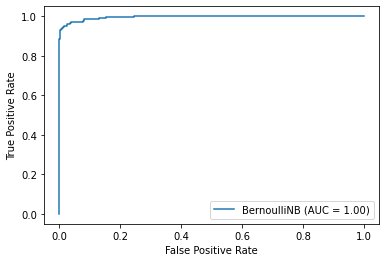

In [14]:
# BernoulliNB. A Naive Bayes classifier for multivariate Bernoulli models.
bern_clf = BernoulliNB().fit(X=X_train_cl, y=y_train_cl)
bern_y_pred = bern_clf.predict(X_test)

print("Accuracy score:\t{}".format(accuracy_score(y_test, bern_y_pred)))

# The F1 score can be interpreted as a weighted average of the precision and
# recall, where an F1 score reaches its best value at 1 and worst score at 0.
f1 = f1_score(y_test, bern_y_pred, average='macro')
print("F1 score:\t{}".format(f1))

bern_disp = plot_roc_curve(bern_clf, X_test, y_test)

#### Multinominal Bernoulli

Accuracy score:	0.9491242702251876
F1 score:	0.9491152089442687


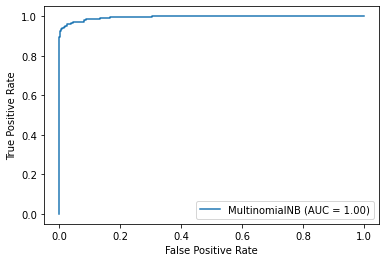

In [15]:
# MultinomialNB. A Naive Bayes classifier for multinominal models.
multi_clf = MultinomialNB().fit(X=X_train, y=y_train)
multi_y_pred = multi_clf.predict(X_test)

print("Accuracy score:\t{}".format(accuracy_score(y_test, multi_y_pred)))

# The F1 score can be interpreted as a weighted average of the precision and
# recall, where an F1 score reaches its best value at 1 and worst score at 0.
f1 = f1_score(y_test, multi_y_pred, average='macro')
print("F1 score:\t{}".format(f1))

multi_disp = plot_roc_curve(multi_clf, X_test, y_test)

#### Comparison of Multivariate and Multinominal Bernoulli

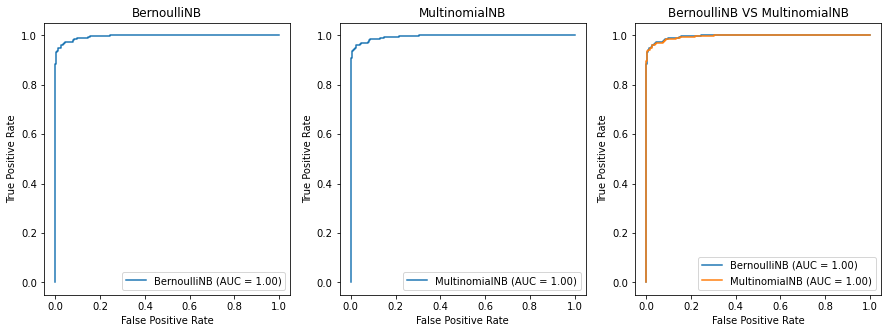

In [16]:
# Printing Multinomial accuracy over previous Bernoulli
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))

ax1.set_title("BernoulliNB")
ax2.set_title("MultinomialNB")
ax3.set_title("BernoulliNB VS MultinomialNB")

bern_disp.plot(ax=ax1)
multi_disp.plot(ax=ax2)
bern_disp.plot(ax=ax3)
multi_disp.plot(ax=ax3)

### Step 2 - Statistic Test

Statistical test to determine whether observed differences are statistically significant between probabilistic classifiers on Multivariate and Multinomial texts


#### Cross Val Score

In [18]:
FOLD = 10

# Bernulli multivariate
clf_BNB = BernoulliNB()
scores_BNB = cross_val_score(clf_BNB, twitter_data, twitter_target, cv=FOLD)
print("BernulliNB:")
# print (scores_BNB)  # array-like print
for (index, value) in enumerate(scores_BNB, start=1):
    print("{0}: {1}".format(index, value))

print("\nAccuracy: {0:.2f} (+/- {1:.2f})\n".format(scores_BNB.mean(),
                                                   scores_BNB.std() * 2))

# Bernulli multinomial
clf_MNB = MultinomialNB()
scores_MNB = cross_val_score(clf_MNB , twitter_data ,  twitter_target, cv=FOLD)
print("Multinomial:")
# print (scores_MNB) # array-like print
for (index, value) in enumerate(scores_MNB, start=1):
    print("{0}: {1}".format(index, value))

print("\nAccuracy: {0:.2f} (+/- {1:.2f})\n".format(scores_MNB.mean(),
                                                   scores_MNB.std() * 2))

BernulliNB:
1: 0.9566305254378649
2: 0.9657762938230384
3: 0.9499165275459098
4: 0.9499165275459098
5: 0.9482470784641068
6: 0.9524207011686143
7: 0.9507512520868113
8: 0.9549248747913188
9: 0.9624373956594324
10: 0.9365609348914858

Accuracy: 0.95 (+/- 0.02)

Multinomial:
1: 0.9541284403669725
2: 0.9649415692821369
3: 0.9499165275459098
4: 0.9482470784641068
5: 0.9440734557595993
6: 0.9474123539232053
7: 0.9490818030050083
8: 0.9499165275459098
9: 0.9616026711185309
10: 0.9373956594323873

Accuracy: 0.95 (+/- 0.02)




#### T-Test

In [19]:
# From Scipy docs:
# "Calculate the t-test on TWO INDIPENDENT samples of scores, a and b"
# for two related samples of scores, see ttest_rel().
t_statistic, p_value = ttest_ind(a=scores_BNB, b=scores_MNB, axis=0)

alpha = 0.05

print('Alpha: {0:.3f}'.format(alpha))
print('T-statistic: {0}'.format(t_statistic))
print('P-value: {0:.3f}'.format(p_value))

if p_value > alpha:
    print('\nP-value >= Alpha ---> Same distribution (fail to reject H0)')
else:
    print('\nP-value <= Alpha ---> Different distribution (reject H0)')

Alpha: 0.050
T-statistic: 0.5809918432440697
P-value: 0.568

P-value >= Alpha ---> Same distribution (fail to reject H0)
